In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

import ALS
import numpy as np
import webbrowser
import pandas as pd
import json
import math
import pickle
import seaborn as sns


## Ratings based recommender system
In order to make our work computable, we decided to work on different dataset sizes for each task :

-Training of the ALS algorithm : top 1000 ranked products for each category (so a total 3000 items)

-Graph visualization : top 50 ranked products for each category (a total 150 items)




In [2]:
R=np.load(open("ratings_mat.npy 2","rb"))  #The pre-processed matrix

The pre-processing steps include filtering out users that rated less than 5 items, to reduce sparsity on the data. This has as side effect to discard some items from the dataset, that were rated exclusively by these users. The data is still sparse with only 46622 ratings in a a 5226 users X 2132 items = 11141832 possible ratings

In [81]:
np.nonzero(R)[0].shape
R.shape


(5226, 2132)

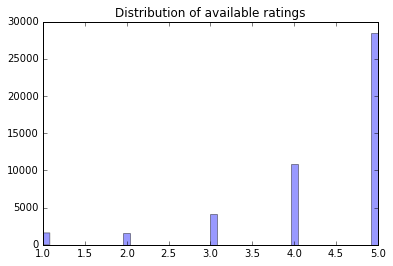

In [17]:
list_of_ratings=[]
for row in R:
    for col in row:
        if (col!=0):
            list_of_ratings.append(col)
sns.distplot(list_of_ratings,kde=False);
plt.title('Distribution of available ratings')

In [3]:
tr,ts=ALS.train_and_test(R) #dividing the dataset into training and validatuon set

Below, we are tuning lambda by running several times

In [4]:
#In the following loop , we compute several times the rmse on the test set for different values of lambda, in order to tune the 
#parameter and find the value that limits the most overfitting the training set
results_for_lambda=[]
for i in range(1,15):
    lambda_=0.03*i
    R_train=ALS.ALS_WR(tr,ts,n_f = 30,l = lambda_,nb_iter_max = 40,epsilon = 0.0001)
    results_for_lambda.append(R_train[-1])
results_for_lambda=np.array(results_for_lambda)

And here, n_f

In [18]:
results_for_nf=[]
for j in range(1,11):
    nf=10*j
    R_train=ALS.ALS_WR(tr,ts,n_f = nf,l = 0.26,nb_iter_max = 40,epsilon = 0.0001)
    print("done for "+str(nf))
    results_for_nf.append(R_train[-1])
results_for_nf=np.array(results_for_nf)

done for 10
done for 20
done for 30
done for 40
done for 50
done for 60
done for 70
done for 80
done for 90
done for 100


In [19]:
rmses_nf=[l[-1] for l in results_for_nf]

In [82]:
final_rmses=[l[-1] for l in results_for_lambda]

In [4]:
#Although we only took into account the lambda that are multiples of 0.03 in the loop, we decided to add the values 0.01 and 0.02 as well 
#as 0.26 and 0.28 who are surrounding the optimal value so far (0.27)
errors=[1.1004329389172476,
 1.0271158330795611,
 0.99717593649334735,
 0.99100829954688574,
 0.98211304301324809,
 0.97629770569808216,
 0.97252265785951664,
 0.96872108909891075,
 0.9655983495417837,
 0.96476276014636586,
 0.9625758557583858,
 0.96371965864177689,
 0.9651699080221414,
 0.96589378033545525]

In [5]:
lambdas=[0.01,0.02,0.03,0.06,0.09,0.12,0.15,0.18,0.21,0.24,0.26,0.27,0.28,0.30]

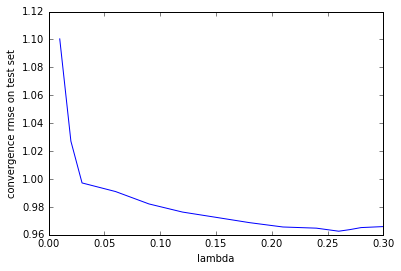

In [6]:
plt.plot(lambdas,errors)
plt.xlabel("lambda")
plt.ylabel("convergence rmse on test set")

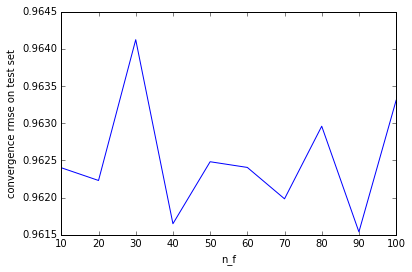

In [20]:
nfs=[10*i for i in range(1,11)]
plt.plot(nfs,rmses_nf)
plt.xlabel("n_f")
plt.ylabel("convergence rmse on test set")

One can easily notice that lambda=0.26 is the value that limits the most overfitting. So we decided to go for this one, train the ALS  and add the computed bias term.

In [63]:
R_trained=ALS.ALS_WR(tr,ts,n_f = 40,l = 0.26,nb_iter_max = 20,epsilon = 0.00001)

In [65]:
I2 = ts.copy()
I2[I2 > 0] = 1
I2[I2 == 0] = 0
    
bias = (ts - I2*R_trained[0]).sum()/(I2.sum())

In [71]:
rR=R_trained[0]+bias
rR[rR > 5] = 5
rR[rR < 1] = 1

In [72]:
from sklearn.metrics import mean_squared_error as mse

I=ts.nonzero()
ALS.rmse(ts,rR,I)
#By adding the rating bias term and rounding the out of scale values, we obtain a testing rmse of 0.868

0.86885207721811619

Starting from the matrix R, the matrix R_pred was computed with ALS matrix factorization algorithm (see report for more details). 

In [87]:
#pickle.dump(rR,open("R_predictions.pkl","wb"))

In [88]:
R_pred=pickle.load(open("R_predictions.pkl","rb"))#Matrix infered by the ALS algorithm, thus with no zero entries

In [140]:
ordinal2asin=pickle.load(open("ordinal2asin.pkl","rb"))
def asin2url(asin):
    return "https://www.amazon.com/dp/"+asin
def make_recommendation_links(usr):
    non_rated=np.where(R[usr]==0)[0]
    inferences=R_pred[usr]
    recommended_items=np.where(inferences>=4.9)[0]
    non_rated_recommended=np.intersect1d(recommended_items,non_rated)
    return pd.Series([asin2url(ordinal2asin[i]) for i in non_rated_recommended])
def make_recommendation_pop(usr):
    #The following method makes one recommendation for a given user ordinal number (from 0 to the number of users)
    #It yields the items that are supposed to be highly rated by the user (but not rated by him) and open a browser window
    #pointing to the amazon page of a random item from this list
    non_rated=np.where(R[usr]==0)[0]
    inferences=R_pred[usr]
    recommended_items=np.where(inferences>=4.9)[0]
    non_rated_recommended=np.intersect1d(recommended_items,non_rated)
    items_asins=[asin2url(ordinal2asin[i]) for i in non_rated_recommended]
    try: 
        toDisplay=np.random.randint(0,len(items_asins)-1)
        webbrowser.open(items_asins[toDisplay])
    except:
        print("No special recommendation for this user")
        


In [141]:
make_recommendation_pop(2000) #the argument must be between 0 and 5225, a valid user number  this method pops a random
#recommended item for the user, item that has a predicted score >=90 for this user

In [146]:
make_recommendation_links(1234)

0    https://www.amazon.com/dp/B000003SRS
1    https://www.amazon.com/dp/B0001XAQUA
2    https://www.amazon.com/dp/B002MG6OO6
3    https://www.amazon.com/dp/B005540EE8
4    https://www.amazon.com/dp/B00IZMKM94
5    https://www.amazon.com/dp/0142403873
dtype: object

All we have are (user,item) rating assumptions. How are we going to use them in order to establish a recommendation from an item to another one? We define it as follows : an item points to another item if, all of the users who have bought it (rated it) are also supposed by our algorithm to rate the other item with five stars (score >=4.75). Roughly speaking, this means that the item2 was recommended systematically for every buyer who rated item1.

In [180]:
def customers(item):
    return np.where(R[:,item]!=0)
def infered_fanbase(item):
    non_rated=np.where(R[:,item]==0)
    return np.intersect1d(np.where(R_pred[:,item]>4.75),np.where(R[:,item]==0))
def recommended_for(item1,item2):
    f1=customers(item1)
    f2=infered_fanbase(item2)
    return ( np.intersect1d(f1,f2).shape[0]==f1[0].shape[0])


Now, let us create the relationships graph between items of the 3 top-50 salesRank charts. Two nodes of this graph will be binded by an edge if its ends are recommended for each other following the signification described above.

In [111]:
elite_index=pickle.load(open("elite_index","rb"))

In [113]:
asin2ordinal=pickle.load(open("asin2ordinal.pkl","rb"))

In [115]:
asin2cat=pickle.load(open("asin2cat.pkl","rb"))
index2title=pickle.load(open("ind2title.pkl","rb"))

In [155]:
elite_ordinal_index=[]
nodes=[]
for ind in elite_index:

    try:
        elite_ordinal_index.append(asin2ordinal[ind])
        nodes.append(dict({"category":asin2cat[ind],"name":index2title[ind],"url":"https://www.amazon.com/dp/"+ind}))
    except:
        pass


In [120]:
len(elite_ordinal_index) #28 of the 150 items were filtered out in the pre-processing and thus will not be featured 
#in the visualization graph

122

In [181]:
edges=[]
for i in range(len(elite_ordinal_index)):
    eoi=elite_ordinal_index[i]
    related=[]
    for j in range(len(elite_ordinal_index)):
        if(recommended_for(eoi,elite_ordinal_index[j])):
            edges.append(dict({"source":i,"target":j}))
        

In [182]:
len(edges)

1122

In [183]:
json.dump(nodes,open("nodesRatings.json","w"),separators=(',\n',":"))
json.dump(edges,open("edgesRatings.json","w"),separators=(',\n',":"))

# Graph Comparison
Now let us compare both graphs with the library networkX. The graphs were realized by linking the top 50 items of each category. The two graphs have very different structures and metrics

In [201]:
import networkx as nx
import json

In [241]:
nodes_sales=json.load(open("nodesMulticat.json","r")) 
edges_sales=json.load(open("edgesMulticat.json","r"))

In [242]:
G1=nx.Graph()
G1.add_edges_from([(k["source"],k["target"]) for k in edges_sales])
G2=nx.Graph()
G2.add_edges_from([(k["source"],k["target"]) for k in edges])


### Nodes degrees 

First, we study the distribution of nodes degree between both graphs. Our first statement is that the average node degree is much higher in the second Graph than it is in the first (much more recommendations made by the second system). Plus, the range of values (see histograms below) is wider, making the second system have a more obvious popularity hierarchy. An important majority of items are related to less than 5 items based on sales, whereas, the dominant range in the second graph is between 10 and 20 neighbors. Plus, there are some central items in the second graph who are related to more than 50 items. This does not exist in the first, where the very maximum is a  30 neighbors degree.

In [297]:
print("mean degree G1: "+str(np.mean(sorted(G1.degree().values())))+" mean degree in G2 : "+str(np.mean(sorted(G2.degree().values()))))

mean degree G1: 8.0 mean degree in G2 : 20.9807692308


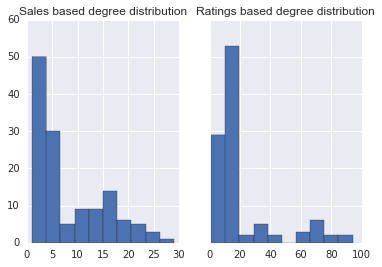

In [279]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.hist(sorted(G1.degree().values()))
ax1.set_title('Sales based degree distribution')
ax2.hist(sorted(G2.degree().values()))
ax2.set_title('Ratings based degree distribution')


plt.show()

### Transitivity

Do our graphs correspond to a clustered structure ? This is what we are about to find out mathematically. The first value, we will compute is transitivity of the graph. It's the proportion of the triple-nodes that are actual fully connected triangles. This metric is twice more important in G1 than in G2, which indicates strong clique-containing structure. This parameter is responsible for the chunky aspect of the first graph. 

In [271]:
nx.transitivity(G1)

0.634648868253047

In [272]:
nx.transitivity(G2)

0.31300856189848947

### Giant component existence

The proportion of the biggest component is a relevant feature of how connected a graph is. If this bigger component gathers more than 50% of the nodes of the whole graph, then it is possible to cross the whole graph after a series of edges.
Since the value for graph 2 is 0.85, then any node within graph 2 can be reached starting from any other one (except the isolated nodes) .

In [291]:
giant1  = max(nx.connected_component_subgraphs(G1), key=len)
giant2  = max(nx.connected_component_subgraphs(G2), key=len)

In [295]:
len(giant1.nodes())/len(nodes_sales)

0.2733333333333333

In [296]:
len(giant2.nodes())/len(nodes)

0.8524590163934426